C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\USER\AppData\Local\Temp\ipykernel_16716\4121576169.py:103: RuntimeWarning: invalid value encountered in divide
  global_mean_intensity = global_intensity_sum / global_bins


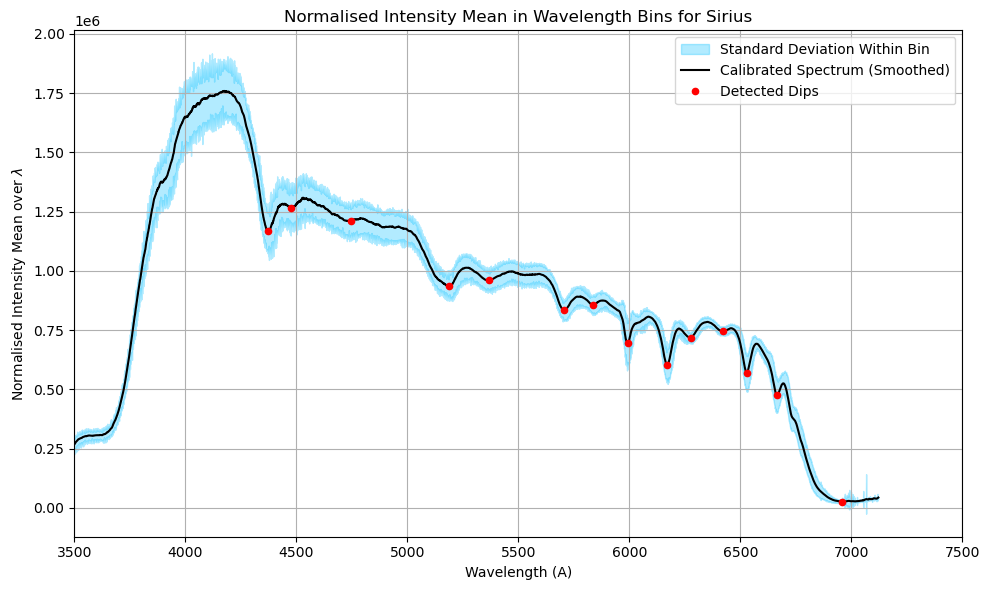

In [18]:
#PLOTTING SPECTRA AND EXTRACTING DIPS DATA

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

stellar_source = 'Sirius'


calibration_coefficients = [-7.87006027e-05, -3.80749635e-02,  7.11501856e+02]

def calibrate_spectrum(pixel_positions):
	return np.polyval(calibration_coefficients, pixel_positions)

min_distance = 10  # Adjust as needed
prominence = 1e4  # Adjust as needed

file_array = []

# Create and open a CSV file for saving the peaks
output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df = pd.read_csv(output_file_name_cropped_data)

#print(df)

output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df_spectra = pd.read_csv(output_file_name_cropped_data)

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'
df_dips = pd.read_csv(output_file_name_dips_data)

weight_file = 'sensor-weight-data.csv'
df_weights = pd.read_csv(weight_file)


optimal_shifts = df_dips['Optimal Shift'].values

# Create bins
bin_width = 1
bins = np.arange(3000, 7500+bin_width, bin_width)  # Adjust bin width as needed5
#print(bins)
global_bins = np.zeros(len(bins) - 1)
global_intensity_sum = np.zeros(len(bins) - 1)
bin_intensity_values = [[] for _ in range(len(bins) - 1)]

def resample_weights(wavelength_range_vega, weight_vega, bins):
	interp_func = interp1d(wavelength_range_vega, weight_vega, kind='linear', fill_value='extrapolate')

	weights_resampled = interp_func(bins)
	
	return weights_resampled


for index, row in df_spectra.iterrows():
	new_intensity_values_along_y = row.iloc[1:].values
	new_intensity_values_along_y = new_intensity_values_along_y * 3 * 1e6 / np.max(new_intensity_values_along_y)
	
	calibrated_wavelengths = 10 * calibrate_spectrum(range(len(new_intensity_values_along_y)))
	spec_shift = optimal_shifts[index]
	calibrated_wavelengths = calibrated_wavelengths + spec_shift
	
	weights_source = resample_weights(df_weights['Wavelength(A)'], df_weights['Weight'], calibrated_wavelengths)

	bin_indices = np.digitize(calibrated_wavelengths, bins, right=True)

	for i, bin_index in enumerate(bin_indices):
		if bin_index > 0 and bin_index < len(bins):
			global_bins[bin_index - 1] += 1
			global_intensity_sum[bin_index - 1] += new_intensity_values_along_y[i]*weights_source[i]
			bin_intensity_values[bin_index - 1].append(new_intensity_values_along_y[i]*weights_source[i])

	#print(global_bins)
	# if index == 0:
	# 	plt.figure(figsize=(10, 6))
	# 	plt.plot(calibrated_wavelengths, new_intensity_values_along_y, color='blue', label='Calibrated Spectrum')
	# 	plt.plot([calibrated_wavelengths[pixel_position] for pixel_position in dips], [new_intensity_values_along_y[pixel_position] for pixel_position in dips], 'ro', markersize=5, label='Detected Dips')
	# 	plt.xlabel('Wavelength (nm)')
	# 	plt.ylabel('Intensity')
	# 	plt.title('Star Spectrum with Detected Dips (Absorption Features)')
	# 	plt.legend()
	# 	plt.grid(True)
	# 	plt.show()
	# 	plt.close()

	# 	print(index)
	# 	print('Detected Dips (Absorption Features):')
	# 	for pixel_position, wavelength in dips_wavelengths.items():
	# 		print(f'Pixel Position: {pixel_position}, Wavelength: {wavelength} nm')
	# 	print()

# Print counts for each bin
# print("Global Bin Counts:")
# print(global_bins)
# print(global_intensity_sum/global_bins)

bin_std_dev = [np.std(values) for values in bin_intensity_values]
bin_std_dev = np.array(bin_std_dev)

bins = bins[:-1] + bin_width
global_mean_intensity = global_intensity_sum / global_bins
global_mean_intensity = np.nan_to_num(global_mean_intensity, nan=0, posinf=0, neginf=0)
non_zero_mask = global_mean_intensity != 0
global_mean_intensity = global_mean_intensity[non_zero_mask]
bins = bins[non_zero_mask]

bin_std_dev = bin_std_dev[non_zero_mask]

smooth = savgol_filter(global_mean_intensity, window_length=30, polyorder=5)
dips, _ = find_peaks(-smooth, distance=min_distance, prominence=prominence)
dips_wavelengths = {pixel_position: bins[pixel_position] for pixel_position in dips}

#STUPIDER
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.3, label='Standard Deviation Within Bin')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='black', label='Calibrated Spectrum (Smoothed)')
plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=4.5, label='Detected Dips')
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title(f'Normalised Intensity Mean in Wavelength Bins for {stellar_source}')
plt.xlim(3500,7500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sirius_obs_spectra = smooth
sirius_obs_bins = bins

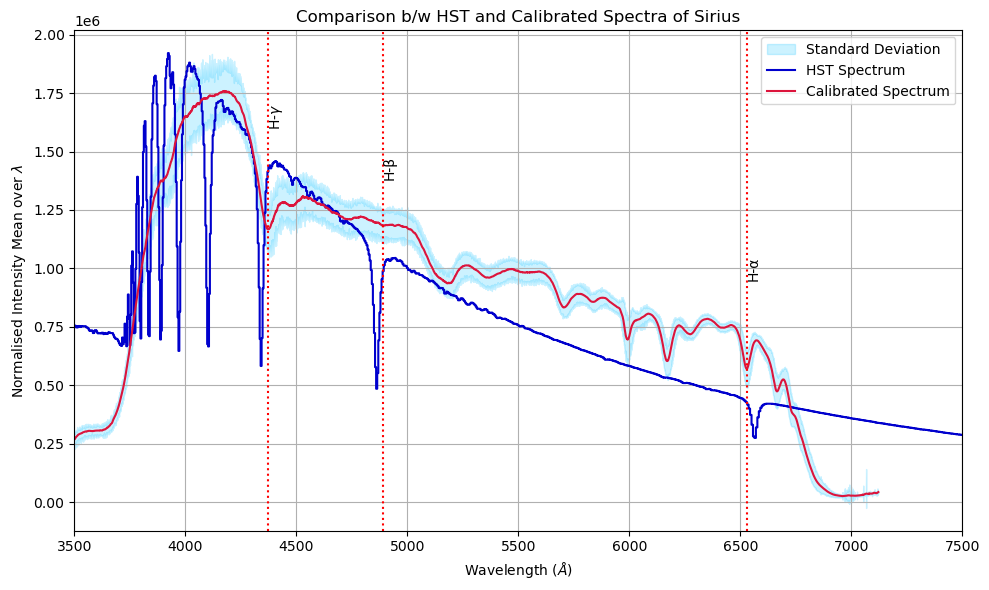

In [19]:
import os
import pysynphot as S

sirius_model_path = 'C:/Users/USER/desktop/Spectroscope/Sirius/sirius_mod_005.fits'

sp = S.FileSpectrum(sirius_model_path)

sirius_flux = sp.flux * 5.5e13

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.2, label='Standard Deviation')
plt.plot(sp.wave, sirius_flux, drawstyle='steps-mid', color='mediumblue', label='HST Spectrum')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='crimson', label='Calibrated Spectrum')
#plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=4.5, label='Detected Dips')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title('Comparison b/w HST and Calibrated Spectra of Sirius')
plt.xlim(3500,7500)
plt.legend()
plt.grid(True)

# Add labels for the lines
h_alpha_wavelength = 6530  
plt.axvline(x=h_alpha_wavelength, color='r', linestyle=':', label='H-α')
plt.text(h_alpha_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-α', rotation=90, verticalalignment='bottom')

h_beta_wavelength = 4891  
plt.axvline(x=h_beta_wavelength, color='r', linestyle=':', label='H-β')
plt.text(h_beta_wavelength, plt.ylim()[1] - 0.3 * (plt.ylim()[1] - plt.ylim()[0]), 'H-β', rotation=90, verticalalignment='bottom')

h_gamma_wavelength = 4374  
plt.axvline(x=h_gamma_wavelength, color='r', linestyle=':', label='H-$\gamma$')
plt.text(h_gamma_wavelength, plt.ylim()[1] - 0.2 * (plt.ylim()[1] - plt.ylim()[0]), 'H-$\gamma$', rotation=90, verticalalignment='bottom')


plt.tight_layout()
plt.savefig('Compared Sirius Spectrum.png')
plt.show()